# Read lengths exploration

In [89]:
from datamap import experiment_files, experiments_dict
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
from ont_fast5_api.fast5_interface import get_fast5_file
from matplotlib import pyplot as plt

skip = 25
exp_lengths = {}
for k in experiment_files.keys():
    file_lengths = {}
    for f in sorted(experiment_files[k], key=lambda x: int(x.stem.split('_')[-1]))[::skip]:
        print(f.stem)
        lengths = []
        with get_fast5_file(f, mode='r') as f5:
            for i,read in enumerate(f5.get_reads()):
                x = read.get_raw_data(scale=True)
                lengths.append(len(x))
        file_lengths[f.stem]=lengths
    exp_lengths[k]= file_lengths
    print(f'EXP {k} done')


FAR89595_30596c4a_0
FAR89595_30596c4a_25
FAR89595_30596c4a_50
FAR89595_30596c4a_75
FAR89595_30596c4a_100
FAR89595_30596c4a_125
FAR89595_30596c4a_150
FAR89595_30596c4a_175
FAR89595_30596c4a_200
FAR89595_30596c4a_225
FAR89595_30596c4a_250
EXP pos_2022 done
FAR56295_37f312c1_0
FAR56295_37f312c1_25
FAR56295_37f312c1_50
FAR56295_37f312c1_75
FAR56295_37f312c1_100
FAR56295_37f312c1_125
FAR56295_37f312c1_150
FAR56295_37f312c1_175
FAR56295_37f312c1_200
FAR56295_37f312c1_225
FAR56295_37f312c1_250
FAR56295_37f312c1_275
FAR56295_37f312c1_300
FAR56295_37f312c1_325
FAR56295_37f312c1_350
FAR56295_37f312c1_375
FAR56295_37f312c1_400
FAR56295_37f312c1_425
FAR56295_37f312c1_450
FAR56295_37f312c1_475
FAR56295_37f312c1_500
EXP neg_2022 done
FAO56186_d9cbe3d3_0
FAO56186_d9cbe3d3_25
FAO56186_d9cbe3d3_50
FAO56186_d9cbe3d3_75
FAO56186_d9cbe3d3_100
FAO56186_d9cbe3d3_125
EXP pos_2020 done
FAO56097_20250069_0
FAO56097_20250069_25
FAO56097_20250069_50
FAO56097_20250069_75
FAO56097_20250069_100
FAO56097_20250069_12

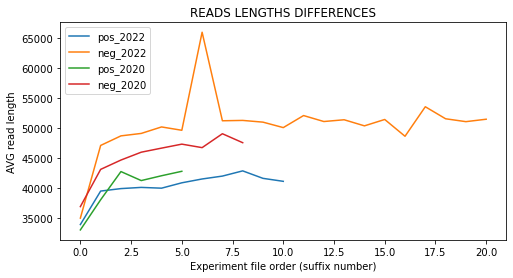

In [90]:
from statistics import mean
# fig, axs = plt.subplots(len(exp_lengths.keys()), sharey=True, figsize=(13,10))
fig, ax = plt.subplots(figsize=(8,4))
for j, (exp, file_lengths) in enumerate(exp_lengths.items()):
    # fig, axs = plt.subplots(len(file_lengths.keys()), sharey=True, figsize=(13,10))
    means = []
    for i,(k,v) in enumerate(file_lengths.items()):
        means.append(int(mean(v)))
        # axs[i].plot(v, label=f'{exp}:MEAN:{int(mean(v))}', color='black')
        # axs[i].legend(loc="upper left")
    ax.plot(means, label=exp)
    
ax.set_title('READS LENGTHS DIFFERENCES')
ax.set_ylabel('AVG read length')
ax.set_xlabel('Experiment file order (suffix number)')
#TODO fix ticks
# ax.set_xticks(range(0,10*skip,skip))
ax.legend(loc="upper left")
pass
#On avg, shorter reads have Modifs, longer do not

# Data standartization/shuffling exploration

In [4]:
from torch.utils.data import DataLoader
from dataloading import get_my_dataset
from datamap import experiment_files

"""
Structure

-experiment0 (positives)
 |
 -fast5file0
     |
     -~4000 reads
 -fast5file1
     |
     -~4000 reads
 -...
-experiment1 (negatives)
 |
 -...
"""

#TODO 2022 vs 2020 data
#TODO window size
#TODO minimum & maximum read lengths
#TODO use fast5 native start-end parameters to speed up training (messes up standartization)

train_dset, valid_dset = get_my_dataset(infinite_random=False, valid_limit=100, valid_files_count=3)

#check if i sample all files equally
counts = {0:0,1:0}
for i in range(100):
    x,y = next(iter(valid_dset))
    counts[(int(y[0]))]+=1
    
counts


{0: 50, 1: 50}

In [10]:
from ont_fast5_api.fast5_interface import get_fast5_file
from pathlib import Path
import random
from datamap import experiment_files

pos_files = experiment_files['pos_2022']
neg_files = experiment_files['neg_2022']


# print('POSITIVES')
# for file in pos_files:
#     with get_fast5_file(file, mode='r') as f5:
#         print(Path(file).stem, ':',len(list(f5.get_reads())))
        
# print('NEGATIVES')
# for file in neg_files:
#     with get_fast5_file(file, mode='r') as f5:
#         print(Path(file).stem, ':',len(list(f5.get_reads())))

#ALl have 4000 reads inside -> ok to randomize across files


In [42]:
from torchmetrics import ConfusionMatrix
import torch
target = torch.tensor([1, 1, 1,0, 0,0,0])
preds = torch.tensor([0, 1,0,1,0, 0,0])
confmat = ConfusionMatrix(num_classes=2, normalize='true')
confmat(preds, target)


tensor([[0.7500, 0.2500],
        [0.6667, 0.3333]])

In [31]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from itertools import islice
from bonito_pulled.bonito.reader import trim
from datamap import experiment_files
import random
from ont_fast5_api.fast5_interface import get_fast5_file
from dataloading import my_trim
from bonito_pulled.bonito.reader import trim



cutoffs = {
    'pos_2020':0,
    'neg_2020':0,
    'pos_2022':0,
    'neg_2022':0,
}

def process_fast5_read(read, window, skip=1000, zscore=True, scale=True, smartskip=True, exp_label=None, total_limit=None):
    """ Normalizes and extracts specified region from raw signal """
    
    #zscore normalization matters - computes statistics from the whole sequence
    start = 0
    end = 1000
    cut = False
    stand_before_cut = True
    if(cut and not stand_before_cut):
        s = read.get_raw_data(scale=scale, start=start, end=end)  # Expensive
    else:
        s = read.get_raw_data(scale=scale)  # Expensive
    
    if zscore:
        s = stats.zscore(s)
        
        
    if(smartskip):
        skip, _ = my_trim(signal=s[:26000], window_size=200, threshold=1.9, min_elements=25)
        
        # skip, _ = trim(signal=s[:26000], window_size=200, threshold_factor=1.9, min_elements=10, medmad_window_multiplier=10)
        # skip, _ = trim(signal=s[:8000], window_size=40, threshold_factor=2.4, min_elements=3)
        
        
    # print('length of a read:', len(s))
    if(window):
        #TODO why do we skip the first 1000 signals?
        pos = random.randint(skip, len(s)-window)
        print('starting position:',pos)
        return s[pos:pos+window].reshape((window, 1))
    if(cut):
        return s[start:end]
    
    if(smartskip):
        cutoffs[exp_label] = skip
        
    if(total_limit):
        return s[:total_limit]
    
    return s


def myite(files, window, index, zscore, scale, smartskip, exp_label, total_limit):
    while True:
        # fast5 = random.choice(files) #TODO ONLY FOR TESTING PURPOSES, UNCOMMENT
        fast5 = files[0] #TODO DELETE
        with get_fast5_file(fast5, mode='r') as f5:
            #Visualization shows index-th read of the file
            read = next(islice(f5.get_reads(), index, None))
            x = process_fast5_read(read, window, zscore=zscore, scale=scale, smartskip=smartskip, exp_label=exp_label, total_limit=total_limit)
            # print('R',Path(fast5).stem)
            yield x.reshape(-1,1).swapaxes(0,1)

# random.seed(42) #deterministic option
def plot_classes(pos_files, neg_files):
    zscore=True
    scale=True
    ite_pos = myite(pos_files, window=None, index=random.randint(0,100), zscore=zscore, scale=scale) # picking from the first 100 reads
    ite_neg = myite(neg_files, window=None, index=random.randint(0,100), zscore=zscore, scale=scale) 
    fig, axs = plt.subplots(2, sharey=True, sharex=True)
    pos_sample = next(ite_pos)[0]
    neg_sample = next(ite_neg)[0]
    axs[0].plot(pos_sample)
    axs[1].plot(neg_sample)
    axs[0].hlines(y=[-2,2], xmin=0, xmax=max(len(pos_sample),len(neg_sample)), colors='red')
    axs[1].hlines(y=[-2,2], xmin=0, xmax=max(len(pos_sample),len(neg_sample)), colors='red')
    
def plot_classes_all(total_limit=None, index=random.randint(0,100)):
    experiment_files['pos_2022']
    experiment_files['neg_2022']
    
    zscore=True
    scale=True
    smartskip = True
    
    ite_pos_2020 = myite(experiment_files['pos_2020'], window=None, index=index, zscore=zscore, scale=scale, smartskip=smartskip, exp_label='pos_2020', total_limit=total_limit) # picking from the first 100 reads
    ite_pos_2022 = myite(experiment_files['pos_2022'], window=None, index=index, zscore=zscore, scale=scale, smartskip=smartskip, exp_label='pos_2022', total_limit=total_limit)
    ite_neg_2020 = myite(experiment_files['neg_2020'], window=None, index=index, zscore=zscore, scale=scale, smartskip=smartskip, exp_label='neg_2020', total_limit=total_limit) 
    ite_neg_2022 = myite(experiment_files['neg_2022'], window=None, index=index, zscore=zscore, scale=scale, smartskip=smartskip, exp_label='neg_2022', total_limit=total_limit) 
    pos_sample_2020 = next(ite_pos_2020)[0]
    pos_sample_2022 = next(ite_pos_2022)[0]
    neg_sample_2020 = next(ite_neg_2020)[0]
    neg_sample_2022 = next(ite_neg_2022)[0]
    
    # vals = [v > 10 for k,v in cutoffs.items()]
    # if all(vals):
    #     return True
    
    print(cutoffs)
    fig, axs = plt.subplots(4, sharey=True, sharex=True, figsize=(10,10))
    axs[0].plot(pos_sample_2020)
    axs[1].plot(neg_sample_2020)
    axs[2].plot(pos_sample_2022)
    axs[3].plot(neg_sample_2022)
    
    max_x = max(len(pos_sample_2020),len(neg_sample_2020),len(pos_sample_2022),len(neg_sample_2022))
    axs[0].hlines(y=[-2,2], xmin=0, xmax=max_x, colors='red')
    axs[0].vlines(x=cutoffs['pos_2020'], color='purple', ymin=-3, ymax=3)
    axs[1].hlines(y=[-2,2], xmin=0, xmax=max_x, colors='red')
    axs[1].vlines(x=cutoffs['neg_2020'], color='purple', ymin=-3, ymax=3)
    axs[2].hlines(y=[-2,2], xmin=0, xmax=max_x, colors='red')
    axs[2].vlines(x=cutoffs['pos_2022'], color='purple', ymin=-3, ymax=3)
    axs[3].hlines(y=[-2,2], xmin=0, xmax=max_x, colors='red')
    axs[3].vlines(x=cutoffs['neg_2022'], color='purple', ymin=-3, ymax=3)
    # return False #TODO remove
    


{'pos_2020': 9010, 'neg_2020': 10410, 'pos_2022': 4410, 'neg_2022': 14810}
time 5.444533109664917
{'pos_2020': 16810, 'neg_2020': 8210, 'pos_2022': 14010, 'neg_2022': 13410}
time 4.743288040161133
{'pos_2020': 11610, 'neg_2020': 13410, 'pos_2022': 12610, 'neg_2022': 11610}
time 1.6580140590667725
{'pos_2020': 11610, 'neg_2020': 13210, 'pos_2022': 9610, 'neg_2022': 9010}
time 3.6113643646240234
{'pos_2020': 14210, 'neg_2020': 12410, 'pos_2022': 10210, 'neg_2022': 19810}
time 3.435015916824341
{'pos_2020': 13410, 'neg_2020': 4810, 'pos_2022': 9210, 'neg_2022': 15810}
time 5.095897674560547
{'pos_2020': 11010, 'neg_2020': 9610, 'pos_2022': 9810, 'neg_2022': 13210}
time 2.8172802925109863
{'pos_2020': 15410, 'neg_2020': 10810, 'pos_2022': 12410, 'neg_2022': 13410}
time 8.917457818984985
{'pos_2020': 8410, 'neg_2020': 210, 'pos_2022': 9610, 'neg_2022': 8210}
time 7.663634300231934
{'pos_2020': 6810, 'neg_2020': 13610, 'pos_2022': 6010, 'neg_2022': 13810}
time 7.4629600048065186
{'pos_2020':

/tmp/ipykernel_4192614/1366466059.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(4, sharey=True, sharex=True, figsize=(10,10))


{'pos_2020': 16810, 'neg_2020': 7210, 'pos_2022': 14210, 'neg_2022': 14010}
time 2.306619167327881
{'pos_2020': 22610, 'neg_2020': 6810, 'pos_2022': 13010, 'neg_2022': 7210}
time 1.6575770378112793
{'pos_2020': 16610, 'neg_2020': 11010, 'pos_2022': 7210, 'neg_2022': 12210}
time 1.6788954734802246
{'pos_2020': 17410, 'neg_2020': 6610, 'pos_2022': 18410, 'neg_2022': 18010}
time 1.640105962753296
{'pos_2020': 14210, 'neg_2020': 11610, 'pos_2022': 13810, 'neg_2022': 6610}
time 1.561098337173462
{'pos_2020': 12210, 'neg_2020': 7610, 'pos_2022': 15410, 'neg_2022': 8810}
time 1.384692668914795
{'pos_2020': 15810, 'neg_2020': 12410, 'pos_2022': 9410, 'neg_2022': 11210}
time 1.6903915405273438
{'pos_2020': 9210, 'neg_2020': 11810, 'pos_2022': 7810, 'neg_2022': 15210}
time 1.2894468307495117
{'pos_2020': 8010, 'neg_2020': 11810, 'pos_2022': 19810, 'neg_2022': 9210}
time 4.110745906829834
average 3.8268474181493124


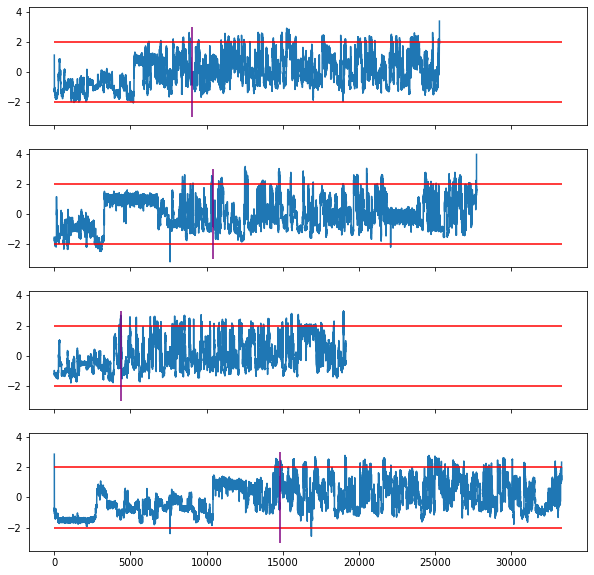

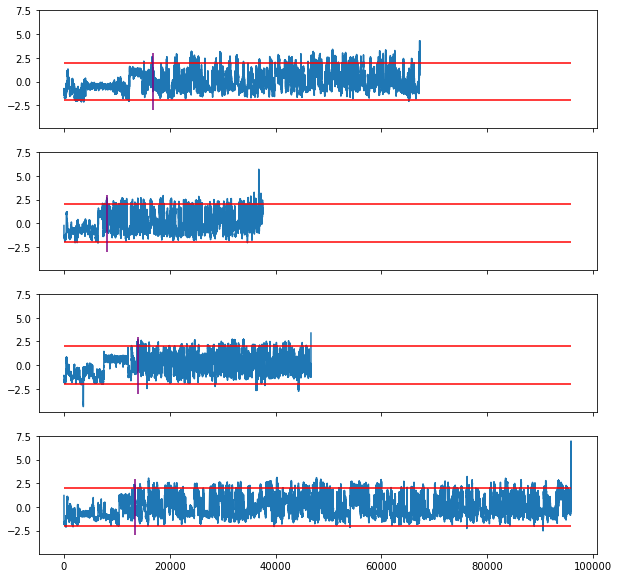

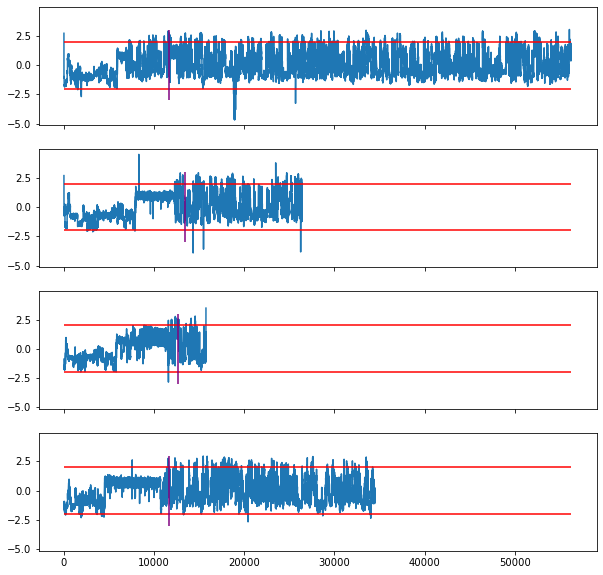

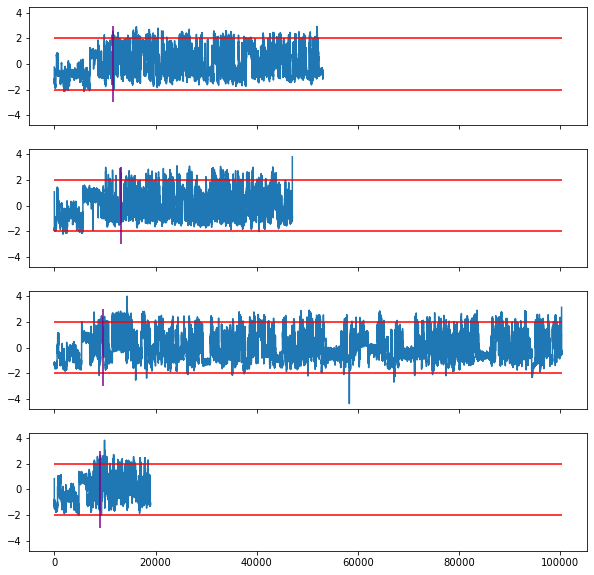

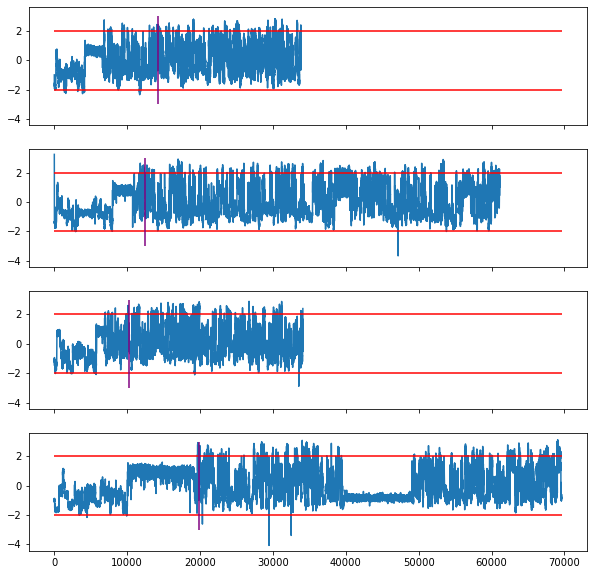

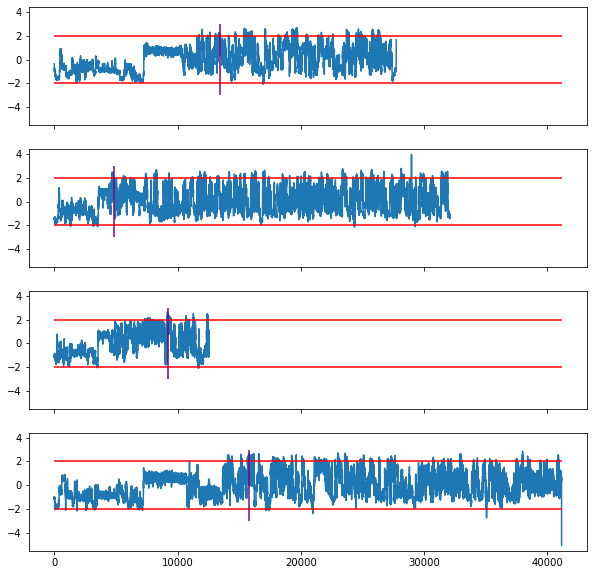

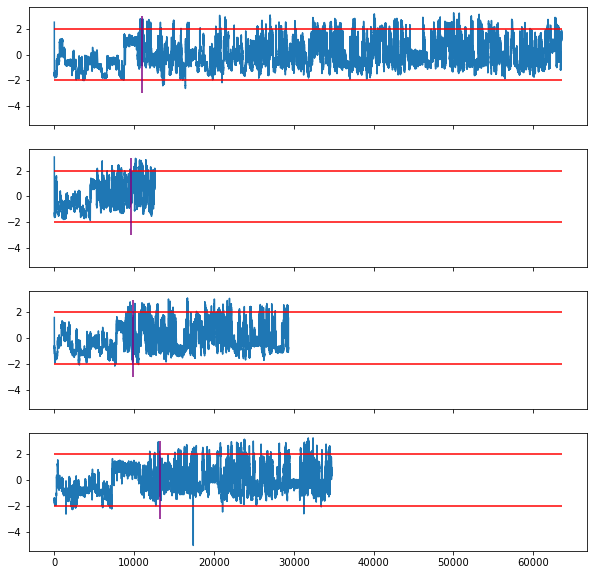

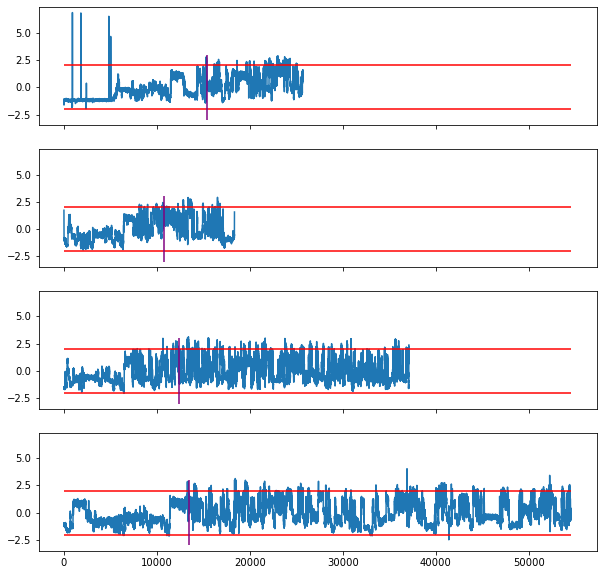

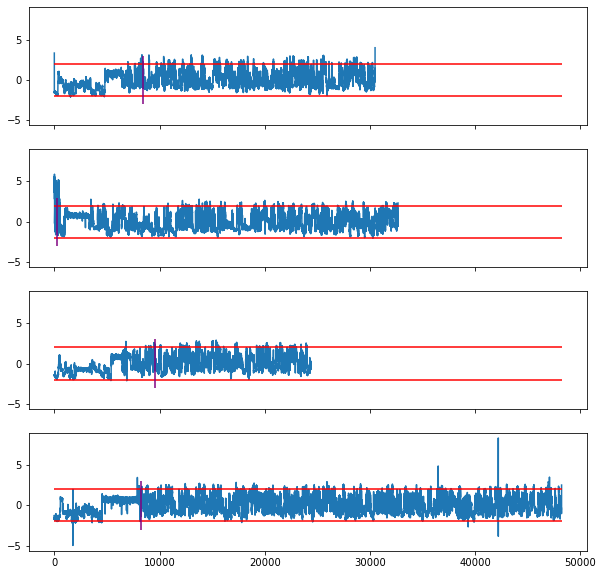

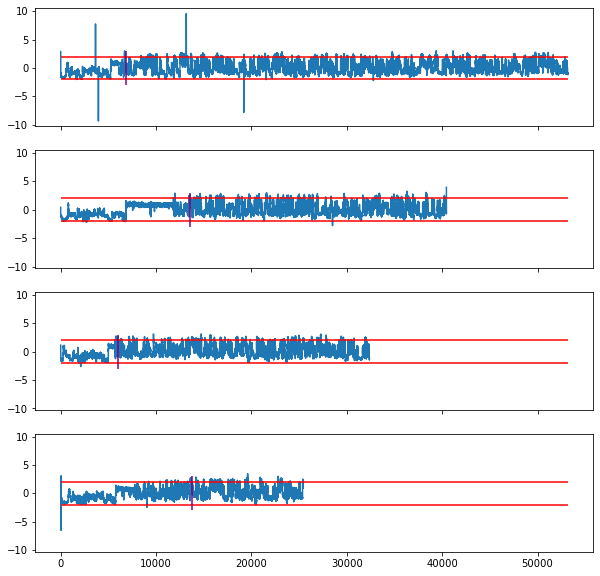

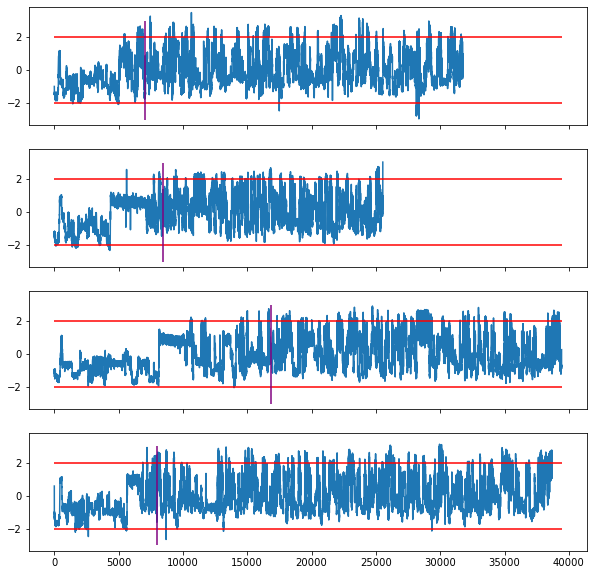

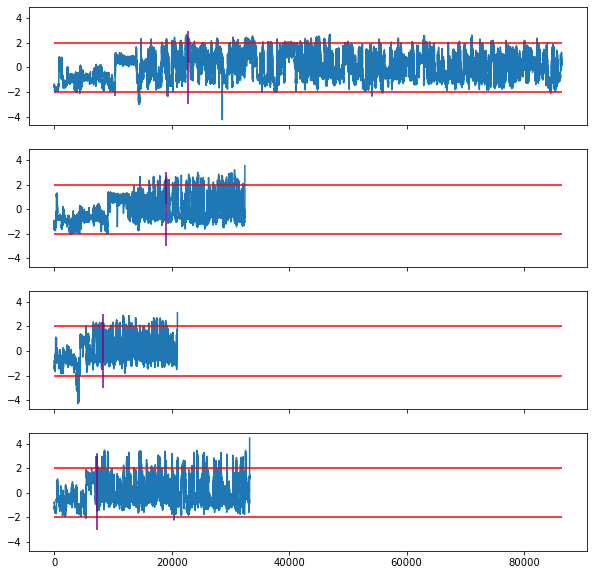

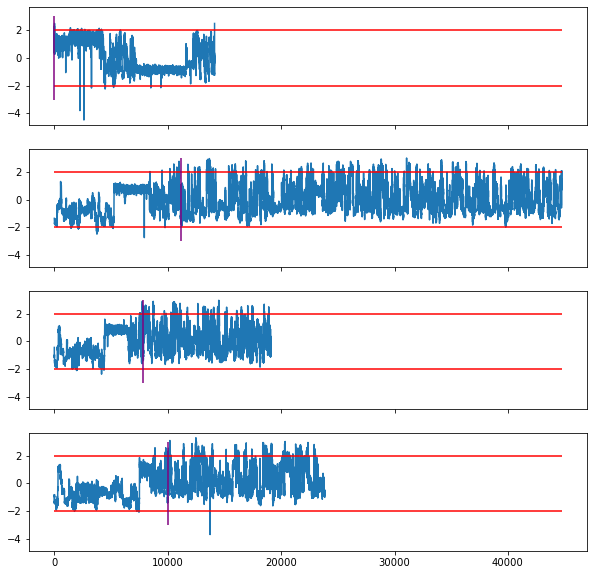

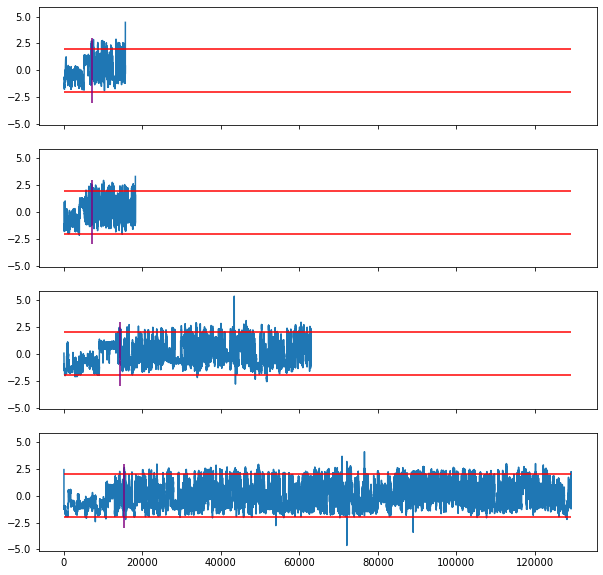

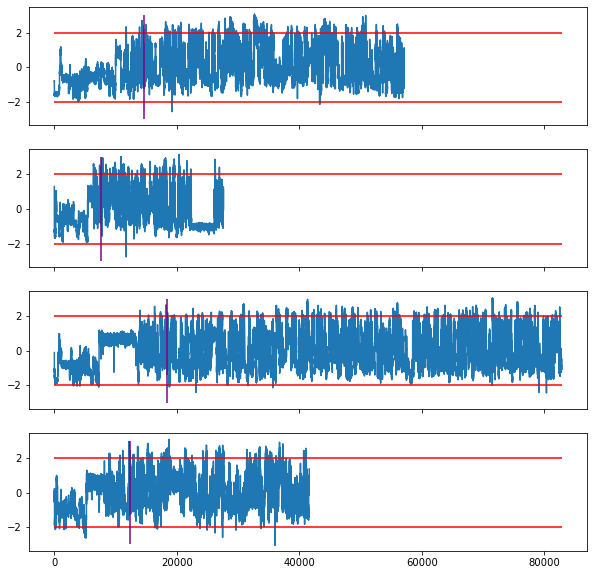

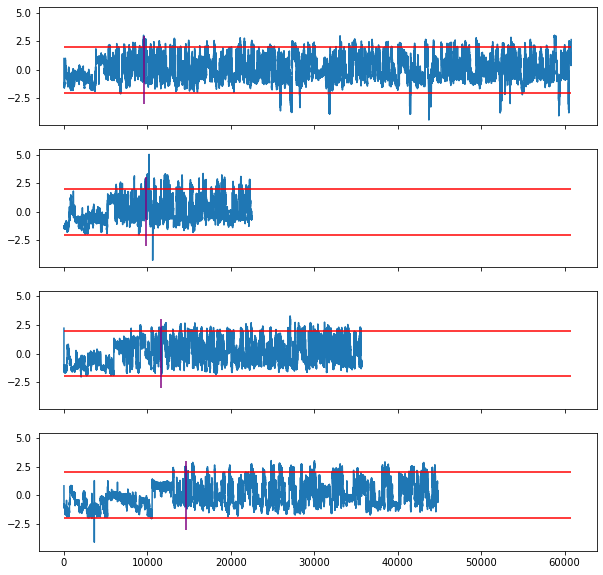

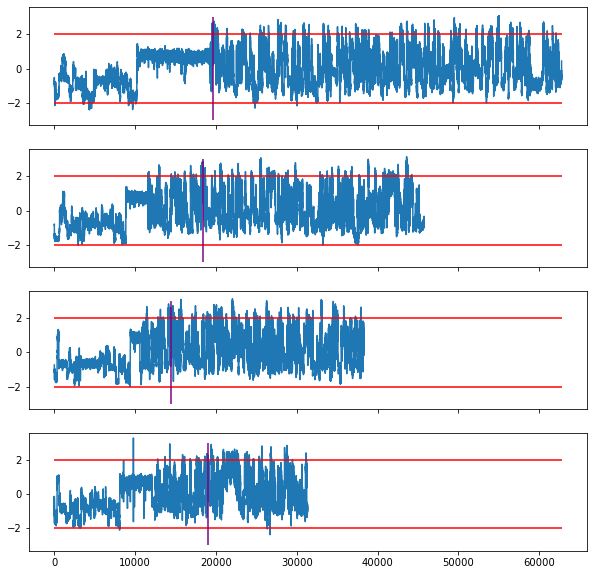

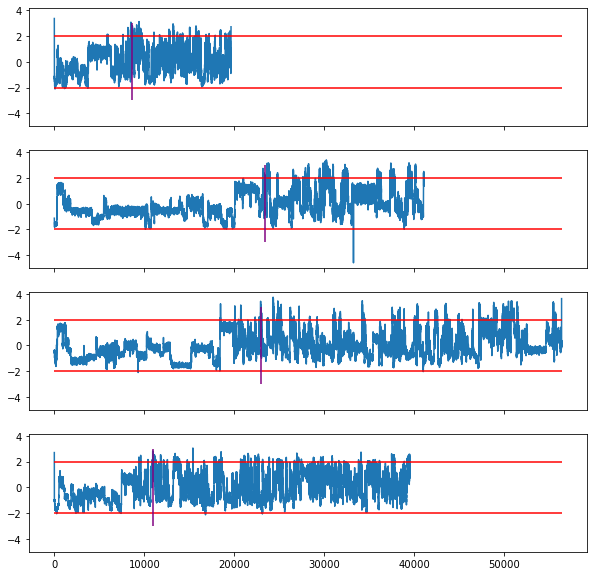

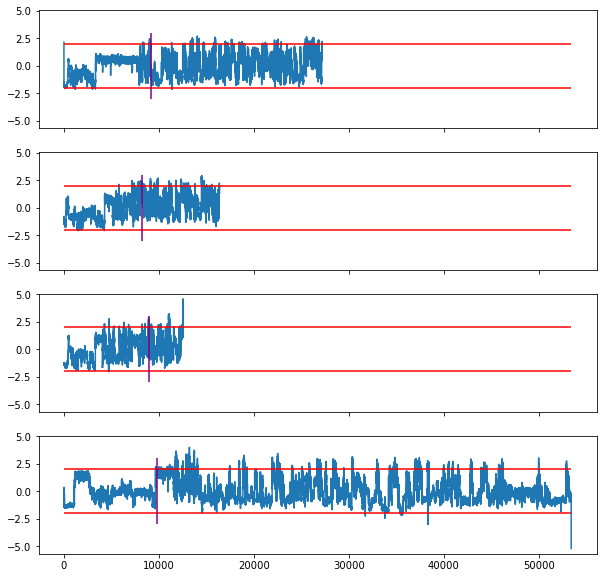

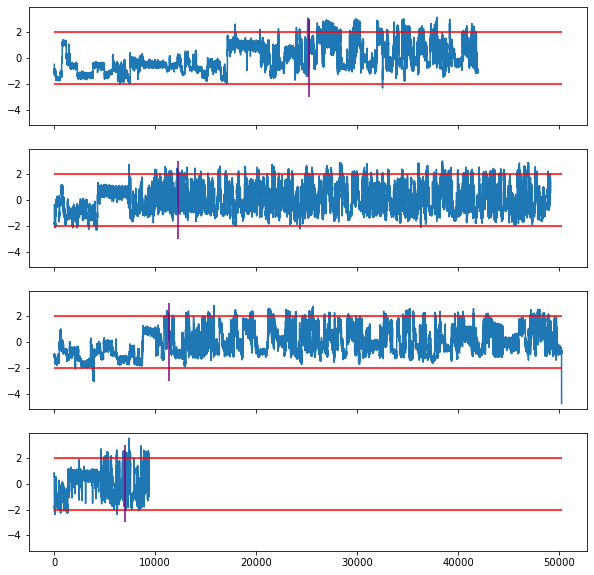

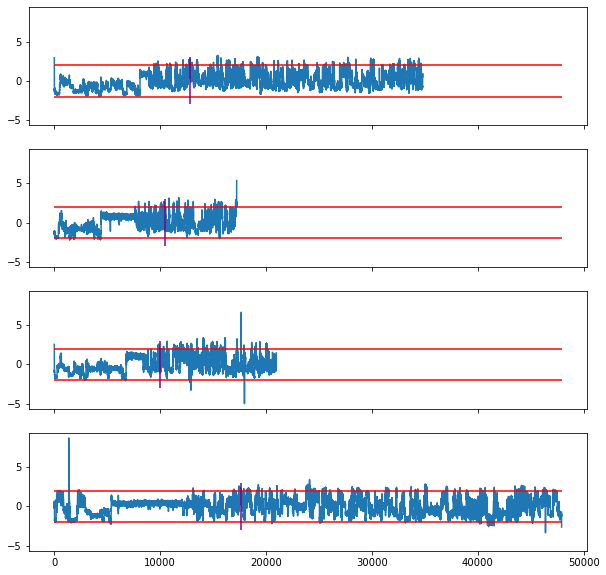

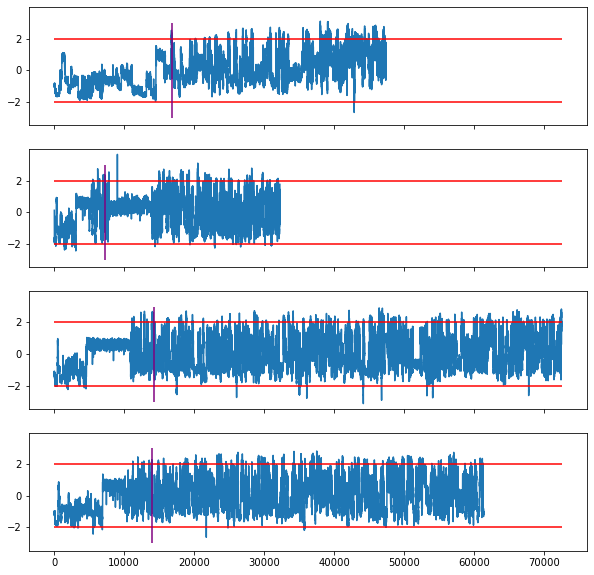

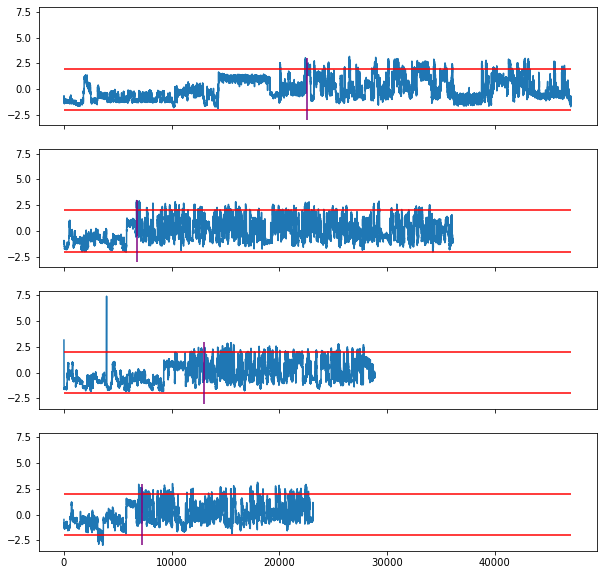

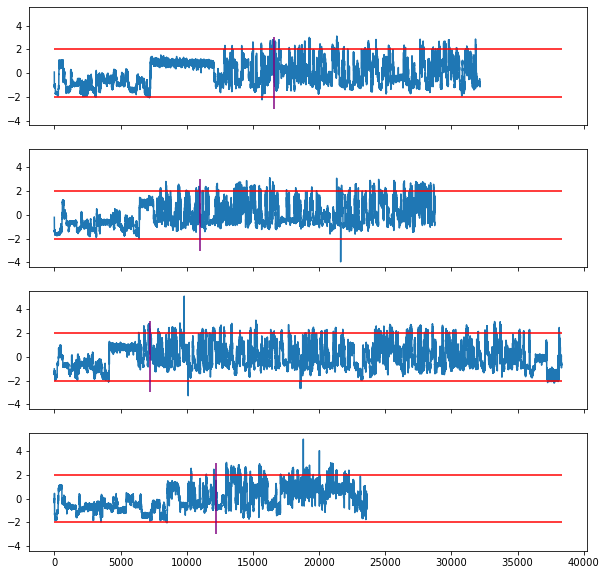

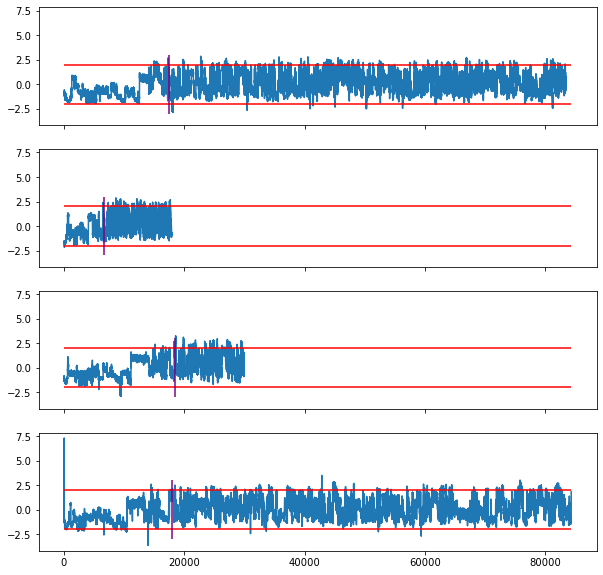

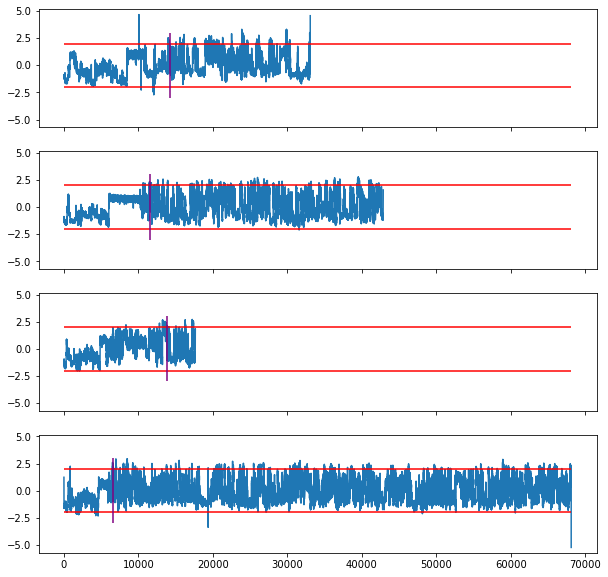

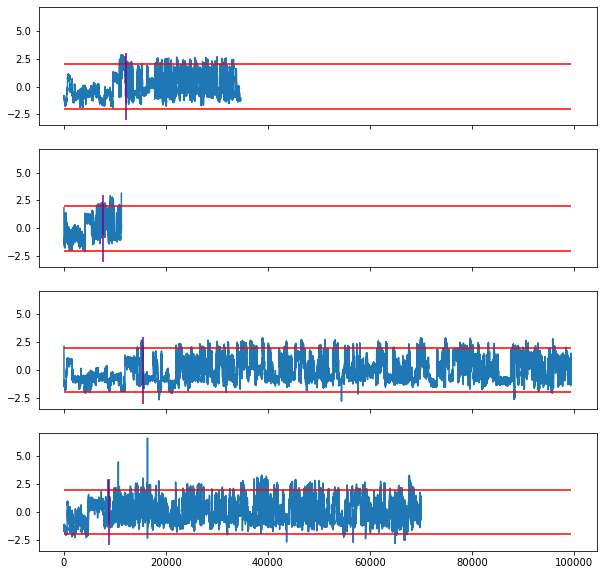

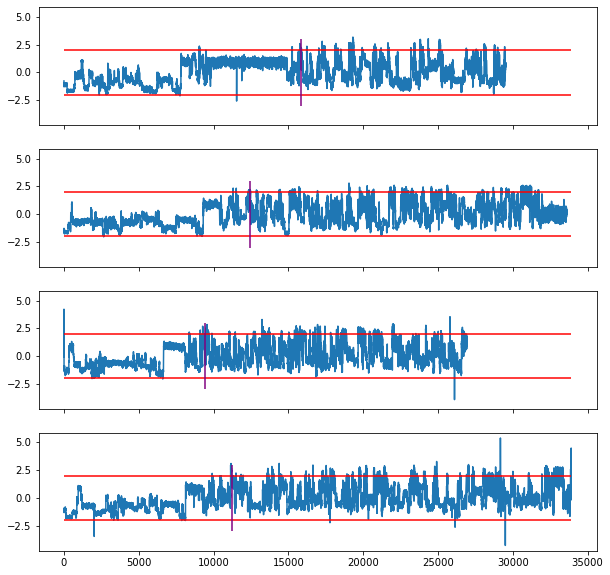

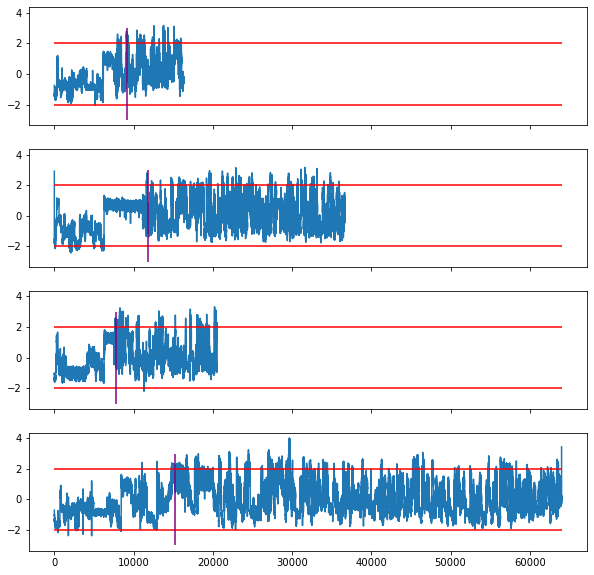

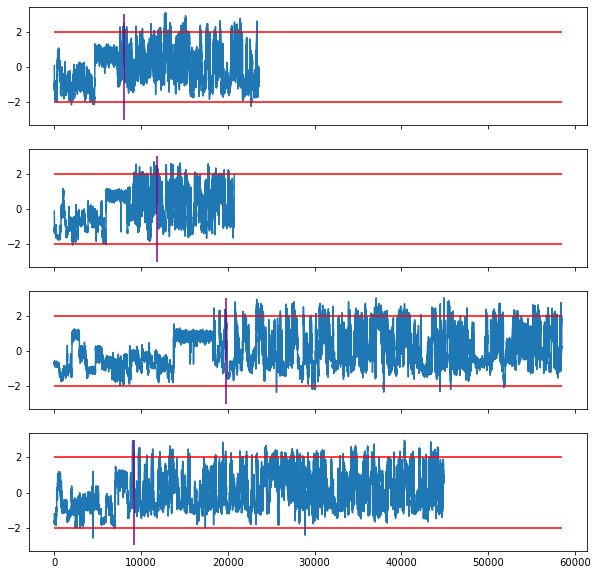

In [32]:
# %%time
import time
from statistics import mean

# for i in range(10):
#     print(i)
#     cont = plot_classes_all(100000)
#     if(not cont):
#         break
#324
times = []
for i in range(30):        
    start = time.time()
    plot_classes_all(None, index=i)
    end = time.time()
    print('time', end-start)
    times.append(end-start)

print('average', mean(times))

In [70]:
from scipy.fft import fft as scipy_fft
import torch
from torch.fft  import fft, ifft, rfft
import torchaudio.transforms
#Fourier transform
fig, axs = plt.subplots(3, sharey=False, sharex=False, figsize=(10,5))
pos_sample_2 = torch.tensor(pos_sample)

axs[0].plot(pos_sample_2)
# axs[1].plot(stats.zscore(fft(pos_sample)))
axs[1].plot(rfft(pos_sample_2)[17000:17500])
axs[2].plot(scipy_fft(pos_sample)[17500:18000])

# fftfreq(10)

# Lengths distribution across labels 

In [3]:
from dataloading import get_my_dataset
from datamap import experiment_files
# get_my_dataset(valid_files_count=3)
# experiment_files['pos_2022']

In [81]:
from datamap import experiment_files, experiments_dict
from Fast5Fetch.fast5fetch.fast5data import get_all_fast5s
from ont_fast5_api.fast5_interface import get_fast5_file
from matplotlib import pyplot as plt
import pickle

exp_lengths = {}
for k in experiment_files.keys():
    file_lengths = {}
    for f in sorted(experiment_files[k], key=lambda x: int(x.stem.split('_')[-1])):
        print(f.stem)
        lengths = []
        with get_fast5_file(f, mode='r') as f5:
            for i,read in enumerate(f5.get_reads()):
                x = read.get_raw_data(scale=True)
                lengths.append(len(x))
        file_lengths[f.stem]=lengths
    exp_lengths[k]= file_lengths
    print(f'EXP {k} done')

    
with open('saved_lengths.pkl', 'wb') as f:
    pickle.dump(exp_lengths, f)
        
# with open('saved_lengths.pkl', 'rb') as f:
    # loaded_dict = pickle.load(f)


In [13]:
from statistics import mean
import pandas as pd
import pickle

data = []
with open('saved_lengths.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
    for exp in loaded_dict.keys():
        print('#'*10, exp)
        subdict = loaded_dict[exp]
        for fast5file in subdict.keys():
            lengths_list = subdict[fast5file]
            for length in lengths_list:
                datapoint = {
                    'exp':exp,
                    'file':fast5file,
                    'len':length,
                    
                }
                data.append(datapoint)
            # print(mean(lengths_list))
df = pd.DataFrame(data)

########## pos_2022
########## neg_2022
########## pos_2020
########## neg_2020


max pos length 7973214
max neg length 10851786
total reads pos 1096408
total reads neg 2076925
[43973 21730 26723 17108 65068 20497 39716 33788 35608 12357]


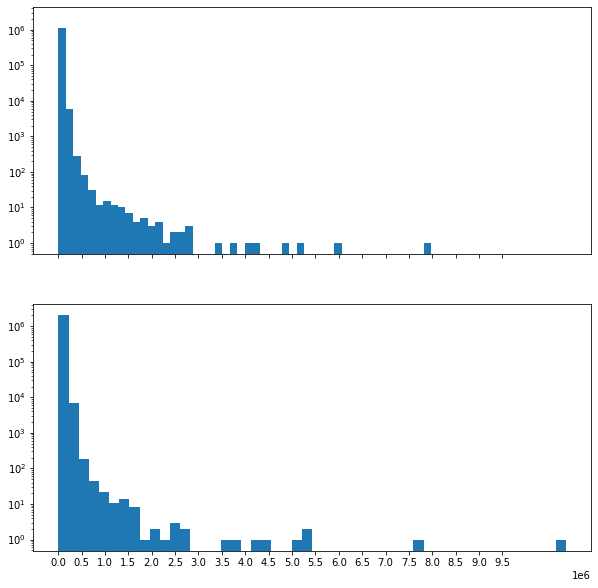

In [26]:
from matplotlib import pyplot as plt

# aggregate_files = False
exp_year = '2022'
pos_sub = df[df['exp'].isin([f'pos_{exp_year}'])]
neg_sub = df[df['exp'].isin([f'neg_{exp_year}'])]
# if(aggregate_files):
    # pos_lengths = pos_sub.groupby('file').agg('mean')['len'].values
    # neg_lengths = neg_sub.groupby('file').agg('mean')['len'].values
# else:
pos_lengths = pos_sub['len'].values
neg_lengths = neg_sub['len'].values

f, a = plt.subplots(2, sharex=True, sharey=True, figsize=(10,10))
plt.ticklabel_format(useOffset=False,style='plain')

# plt.xlim([0, max(neg_lengths)])

# a[0].hist(pos_lengths, 25)
# a[1].hist(neg_lengths, 25)
#TODO display log of lengths
a[0].hist(pos_lengths, bins=50, cumulative=False, log=True, density=False)
a[1].hist(neg_lengths, bins=50, cumulative=False, log=True, density=False)
plt.xticks(np.arange(0, 1e7, 5e5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
print('max pos length',max(pos_lengths))
print('max neg length', max(neg_lengths))
print('total reads pos',len(pos_lengths))
print('total reads neg', len(neg_lengths))
print(pos_lengths[:10])
#TODO do distribution

In [31]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_factory(exp1, exp2, aggregate_files=False):
    def objective(trial):
        threshold = trial.suggest_int('x', 0, 1000000)
        pos_sub = df[df['exp'].isin([exp1])]
        neg_sub = df[df['exp'].isin([exp2])]
        
        if(aggregate_files):
            pos_lengths = pos_sub.groupby('file').agg('mean')['len'].values
            neg_lengths = neg_sub.groupby('file').agg('mean')['len'].values
        else:
            pos_lengths = pos_sub['len'].values
            neg_lengths = neg_sub['len'].values
            
        pos_perc = sum(pos_lengths < threshold)/len(pos_lengths)
        neg_perc = sum(neg_lengths > threshold)/len(neg_lengths)
        return (pos_perc+neg_perc)/2
    return objective

def run_threshold(exp1, exp2, trials=250, agg_files=False):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_factory(exp1, exp2, agg_files), n_trials=trials)

    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return trial.value

In [36]:
import itertools
def get_length_based_acc(agg_files):
    experiments = ['pos_2022', 'neg_2022', 'pos_2020', 'neg_2020']
    combs = list(itertools.combinations(experiments, 2))
    results = []
    for exp1, exp2 in combs:
        acc = run_threshold(exp1, exp2, agg_files=agg_files)
        results.append([exp1, exp2, acc])
    return results

In [38]:
readwise_results = get_length_based_acc(agg_files=False)

  Value:  0.5631598394259446
  Params: 
    x: 40721
  Value:  0.5096248272114465
  Params: 
    x: 40880
  Value:  0.5515924234662197
  Params: 
    x: 38899
  Value:  0.500006934887959
  Params: 
    x: 986425
  Value:  0.5007653955554808
  Params: 
    x: 15260
  Value:  0.5425644746227534
  Params: 
    x: 36325


In [39]:
filewise_results = get_length_based_acc(agg_files=True)

  Value:  0.9861013986013987
  Params: 
    x: 43643
  Value:  0.5127272727272727
  Params: 
    x: 42470
  Value:  0.5
  Params: 
    x: 555828
  Value:  0.5
  Params: 
    x: 917213
  Value:  0.5
  Params: 
    x: 835646
  Value:  0.9769622331691297
  Params: 
    x: 43173


In [44]:
readwise_results

[['pos_2022', 'neg_2022', 0.5631598394259446],
 ['pos_2022', 'pos_2020', 0.5096248272114465],
 ['pos_2022', 'neg_2020', 0.5515924234662197],
 ['neg_2022', 'pos_2020', 0.500006934887959],
 ['neg_2022', 'neg_2020', 0.5007653955554808],
 ['pos_2020', 'neg_2020', 0.5425644746227534]]

In [45]:
filewise_results

[['pos_2022', 'neg_2022', 0.9861013986013987],
 ['pos_2022', 'pos_2020', 0.5127272727272727],
 ['pos_2022', 'neg_2020', 0.5],
 ['neg_2022', 'pos_2020', 0.5],
 ['neg_2022', 'neg_2020', 0.5],
 ['pos_2020', 'neg_2020', 0.9769622331691297]]

# Testing heterogenity of batches

In [7]:
from torch.utils.data import DataLoader

from dataloading import get_demo_dataset, get_my_dataset
train_dset, valid_dset = get_my_dataset(valid_limit=10, valid_files_count=10, window=1000)
# train_loader = DataLoader(train_dset, batch_size=64)

train_loader = DataLoader(train_dset, batch_size=64, num_workers=32,
                          pin_memory=True, persistent_workers=True)
# valid_loader = DataLoader(valid_dset, batch_size=64, num_workers=32,
#                           pin_memory=True, persistent_workers=True)

train_loader

valid files indicies
[15, 46, 109, 112, 138, 145, 162, 200, 210, 224]
[74, 79, 111, 144, 184, 251, 295, 316, 473, 497]


In [ ]:
#TODO try to evaluate only on samples where threshold <0.1 or >0.9 -> compute accuracy on confident samples only, rest undecided 

In [8]:
loader_iterator = iter(train_loader)
# loader_valid_iterator = iter(valid_loader)
#TODO try also validation set

SKIP too longSKIP too long  SKIP too long76907690  SKIP too long SKIP too long76906845 6845SKIP too longSKIP too long 
SKIP too long7690SKIP too long
  SKIP too long   SKIP too long 6845SKIP too longSKIP too long76907690 7690 6845 7690SKIP too long7690 SKIP too long 
SKIP too long6845SKIP too long SKIP too longSKIP too long  7690
7690
   7690    76907690 769068457690 684576907690 6845 6845  
  6845
 6845
SKIP too long
6845684568457690SKIP too long684568456845


6845 

  

SKIP too long
7690
SKIP too long  7690769076906845    
684568456845
6845


SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845
SKIP too long 7690 6845


In [9]:
x, y = next(loader_iterator)

In [10]:
import numpy as np
unique, counts = np.unique(y.numpy().flatten(), return_counts=True)
counts


array([34, 30])

In [11]:
unique, counts = np.unique(x.numpy()[:,:,0].flatten(), return_counts=True)
assert(len(counts)) == 64
unique

array([-1.3734828 , -1.3412325 , -1.3369563 , -1.3153783 , -1.2155182 ,
       -1.0326864 , -0.93167347, -0.90613925, -0.82039803, -0.8193726 ,
       -0.75711274, -0.7520199 , -0.7076745 , -0.70751935, -0.6592823 ,
       -0.6256715 , -0.60970014, -0.56676483, -0.5325577 , -0.49009112,
       -0.42002878, -0.41326377, -0.4017004 , -0.31449443, -0.292732  ,
       -0.275979  , -0.26612425, -0.26508838, -0.24041115, -0.21250728,
       -0.20471323, -0.16119187, -0.1474503 , -0.11934522, -0.0610728 ,
       -0.05974193,  0.03523112,  0.05251919,  0.07996623,  0.2541798 ,
        0.3647546 ,  0.3786981 ,  0.4878905 ,  0.6803979 ,  0.771999  ,
        0.82099795,  0.87715524,  0.88317287,  0.89286023,  0.99338144,
        1.0311135 ,  1.0450617 ,  1.0596194 ,  1.1122091 ,  1.1556405 ,
        1.220845  ,  1.2444533 ,  1.2780894 ,  1.2796129 ,  1.3070749 ,
        1.4022031 ,  1.6382208 ,  1.6821312 ,  1.7387931 ], dtype=float32)

In [12]:
iterations = 100
loader_iterator = iter(train_loader)
ratios = []
for i in range(iterations):
    x, y = next(loader_iterator)
    unique, counts = np.unique(y.numpy().flatten(), return_counts=True)
    ratio = counts[0]/counts[1]
    ratios.append(ratio)

#ratio should be 1, oterwise one label is overrepresented
print(sum(ratios)/len(ratios))

1.0216917933529652


In [55]:
def malf(thresh):
    while True:
        if(thresh > 0.5):
            yield 0
        yield 1
        # else:
            # yield 1

it = malf(0.8)

generated_data = []
for _ in range(10):
    generated_data.append(next(it))
generated_data

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]